In [1]:
pip install pydotplus

     |████████████████████████████████| 278 kB 910 kB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24575 sha256=98ed81471856d6acd900527c558593ce9c545dcdf69235a9d8e4e65e07a7953c
  Stored in directory: /root/.cache/pip/wheels/1e/7b/04/7387cf6cc9e48b4a96e361b0be812f0708b394b821bf8c9c50
Successfully built pydotplus
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Others required libraries 
import re
import emoji
import numpy as np
import pandas as pd
import seaborn as sns
import pydotplus as pyd
import matplotlib.pyplot as plt
from prettytable import PrettyTable

#Sklearn 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

#tensorflow
import keras
import tensorflow as tf
from keras import backend as K
from tensorflow.keras import optimizers
from keras.models import Model, load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical,plot_model
from keras.layers import Dense, Input, Flatten, Embedding, Conv1D, MaxPooling1D, concatenate
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau


#Gensim for word2vec
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [3]:
headline_df = pd.read_csv('../input/sentiment-analysis-for-financial-news/all-data.csv', sep=',', encoding='latin-1',names = ["category","comment"])

In [4]:
headline_df.head()

,category,comment
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


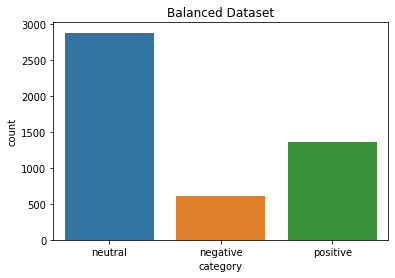

In [5]:
sns.countplot(x = 'category', data = headline_df)
plt.title('Balanced Dataset')
plt.savefig('Balanced_Sarcasm_Label_To_Count.png' , dpi = 300 , transparent = 'true')
plt.show()

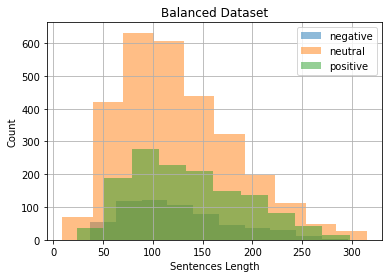

In [6]:
headline_df.loc[headline_df['category'] == 'negative', 'comment'].str.len().hist(label = 'negative', alpha=0.5)
headline_df.loc[headline_df['category'] == 'neutral', 'comment'].str.len().hist(label = 'neutral', alpha=0.5)
headline_df.loc[headline_df['category'] == 'positive', 'comment'].str.len().hist(label = 'positive', alpha=0.5)
plt.title('Balanced Dataset')
plt.ylabel('Count')
plt.xlabel('Sentences Length')
plt.legend()
plt.savefig('Balanced_Sarcasm_Label_By_Sentences_Length.png' , dpi = 300 , transparent = 'true')

In [7]:
headline_df['comment'] = headline_df['comment'].astype(str)

In [8]:
tokens = Tokenizer(oov_token = '<OOV>')
tokens.fit_on_texts(headline_df['comment'].values)
vocab_size = len(tokens.word_index) + 1
print(vocab_size)

10124


In [9]:
encoded_train = tokens.texts_to_sequences(headline_df['comment'])

In [10]:
max_length   = 200
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating='post')

In [11]:
print(headline_df['comment'].iloc[100])
print(encoded_train[100])
print(padded_train[100])

Both operating profit and turnover for the three-month period increased , respectively from EUR0 .9 m and EUR8 .3 m , as compared to the corresponding period in 2005 .
[193, 43, 32, 5, 355, 8, 2, 265, 263, 51, 110, 612, 14, 209, 61, 35, 5, 2382, 39, 35, 21, 78, 6, 2, 100, 51, 4, 112]
[ 193   43   32    5  355    8    2  265  263   51  110  612   14  209
   61   35    5 2382   39   35   21   78    6    2  100   51    4  112
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0

In [12]:
#label encoding
from sklearn.preprocessing import LabelEncoder
headline_df['encoded_category'] = LabelEncoder().fit_transform(headline_df['category'])
headline_df[["category", "encoded_category"]] 

,category,encoded_category
0,neutral,1
1,neutral,1
2,negative,0
3,positive,2
4,positive,2
...,...,...
4841,negative,0
4842,neutral,1
4843,negative,0
4844,negative,0


In [13]:
headline_df["encoded_category"] = headline_df["encoded_category"].astype(str)

In [14]:
y = headline_df["encoded_category"].values
y = to_categorical(y, num_classes=3)

In [15]:
# Splitting into training sets and validation sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_train, y, test_size = 0.2, random_state = 0)

In [16]:
w2v_model = KeyedVectors.load_word2vec_format('../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin', binary=True)

In [17]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokens.word_index.items():
    try:
        embedding_vector = w2v_model[word]
    except:
        embedding_vector = [0]*300
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

(10124, 300)

In [18]:
def recall_m(y_true, y_pred):
        true_positives     = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall             = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives      = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision           = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall    = recall_m(y_true, y_pred)
    return    2*((precision*recall)/(precision+recall+K.epsilon()))

In [19]:
input_data        = Input(shape = (max_length, ), name = 'Train_Set')
embedding_layer   = Embedding(vocab_size, 300, weights = [embedding_matrix], trainable = False, name = 'Word2Vec_Embedding')(input_data)
conv_1            = Conv1D(filters=50, kernel_size=4, activation='relu',name='Convolutional1D_1')(embedding_layer)
max_1             = MaxPooling1D(pool_size=2,name='MaxPooling_1')(conv_1)
conv_2            = Conv1D(filters=100, kernel_size=3, activation='relu',name='Convolutional1D_2')(max_1)
max_2             = MaxPooling1D(pool_size=2,name='MaxPooling_2')(conv_2)
flatten           = Flatten(name='Flatten_Layer')(max_2)
dense             = Dense(100, activation='relu', name='Fully_Connected_Layer')(flatten)
out               = Dense(3, activation='softmax',name='Output_Layer')(dense)
baseline_model   = Model(inputs=[input_data], outputs=[out], name = 'Baseline_Model')
# feature_extractor = Model(inputs=[input_data], outputs=[flatten], name = 'Feature_Extracter' )

print(baseline_model.summary())

Model: "Baseline_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Train_Set (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
Word2Vec_Embedding (Embeddin (None, 200, 300)          3037200   
_________________________________________________________________
Convolutional1D_1 (Conv1D)   (None, 197, 50)           60050     
_________________________________________________________________
MaxPooling_1 (MaxPooling1D)  (None, 98, 50)            0         
_________________________________________________________________
Convolutional1D_2 (Conv1D)   (None, 96, 100)           15100     
_________________________________________________________________
MaxPooling_2 (MaxPooling1D)  (None, 48, 100)           0         
_________________________________________________________________
Flatten_Layer (Flatten)      (None, 4800)           


User settings:

   KMP_AFFINITY=granularity=fine,noverbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER

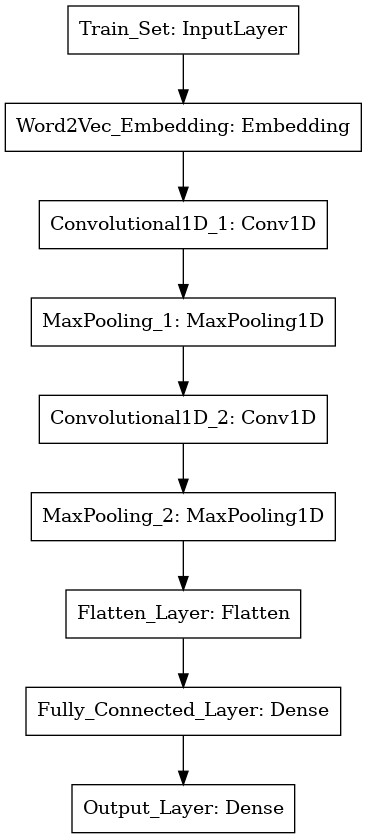

In [20]:
keras.utils.vis_utils.pydot = pyd
plot_model(baseline_model, to_file='baseline_model.png')

In [21]:
tensorboard = TensorBoard(log_dir='baseline_model')

reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = ModelCheckpoint("baseline_model.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 5,
                            verbose=1)

2022-10-30 06:58:00.267136: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-30 06:58:00.267424: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-30 06:58:00.268709: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [22]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

baseline_model.compile(optimizer = adam_optimizer, loss='categorical_crossentropy', metrics=[f1_m,'acc',recall_m,precision_m])
history = baseline_model.fit(X_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, 
               callbacks=[checkpoint, earlystop, reduce_lr], 
               validation_data=(X_test, y_test))

2022-10-30 06:58:00.455048: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
61/61 [==============================] - 6s 77ms/step - loss: 0.9830 - f1_m: 0.3102 - acc: 0.5632 - recall_m: 0.2853 - precision_m: 0.3795 - val_loss: 0.9285 - val_f1_m: 0.5757 - val_acc: 0.5928 - val_recall_m: 0.5635 - val_precision_m: 0.5889

Epoch 00001: val_f1_m improved from -inf to 0.57575, saving model to baseline_model.h5
Epoch 2/50
61/61 [==============================] - 5s 84ms/step - loss: 0.8872 - f1_m: 0.5969 - acc: 0.5965 - recall_m: 0.5668 - precision_m: 0.6331 - val_loss: 0.8824 - val_f1_m: 0.6138 - val_acc: 0.6041 - val_recall_m: 0.5766 - val_precision_m: 0.6569

Epoch 00002: val_f1_m improved from 0.57575 to 0.61382, saving model to baseline_model.h5
Epoch 3/50
61/61 [==============================] - 4s 71ms/step - loss: 0.8334 - f1_m: 0.6067 - acc: 0.6267 - recall_m: 0.5458 - precision_m: 0.6849 - val_loss: 0.8318 - val_f1_m: 0.6089 - val_acc: 0.6474 - val_recall_m: 0.5469 - val_precision_m: 0.6877

Epoch 00003: val_f1_m did not improve from 0.61382
Epoc

In [23]:
baseline_model.save(f'./cnn.h5')

In [24]:
score = baseline_model.evaluate(X_test, y_test)

31/31 [==============================] - 0s 14ms/step - loss: 0.6511 - f1_m: 0.7703 - acc: 0.7701 - recall_m: 0.7637 - precision_m: 0.7772


In [25]:
pretty_table = PrettyTable()
pretty_table.field_names = ['Parameters','Value']
pretty_table.add_row(['Loss Score'                     ,score[0]])
pretty_table.add_row(['F1 Score'                       ,score[1]])
pretty_table.add_row(['Accuracy Score'                 ,score[2]])
pretty_table.add_row(['Recall Score'                   ,score[3]])
pretty_table.add_row(['Precision Score'                ,score[4]])

print(pretty_table)

+-----------------+--------------------+
|    Parameters   |       Value        |
+-----------------+--------------------+
|    Loss Score   | 0.6510633826255798 |
|     F1 Score    | 0.7702782154083252 |
|  Accuracy Score | 0.7701030969619751 |
|   Recall Score  | 0.7637096643447876 |
| Precision Score | 0.7772195339202881 |
+-----------------+--------------------+


[[ 77  27  24]
 [ 14 483  78]
 [ 11  69 187]]


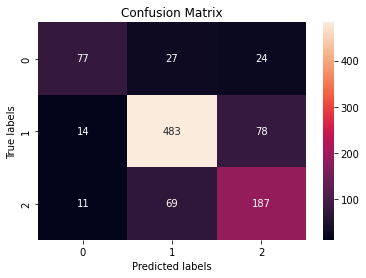

In [26]:
cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(baseline_model.predict(X_test), axis=1))

print(cnf_mat)
labels = [0,1,2]
ax= plt.subplot()
# labels, title and ticks
sns.heatmap(cnf_mat, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);


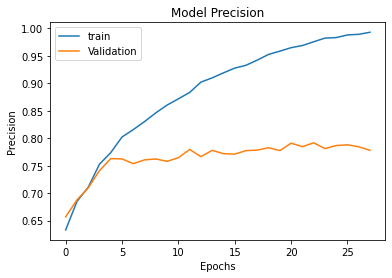

In [27]:
plt.plot(history.history['precision_m'][1:])
plt.plot(history.history['val_precision_m'][1:])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epochs')
# plt.ylim([0.7, 0.8])
plt.legend(['train','Validation'], loc='upper left')
plt.savefig('Model_Precision.png' , dpi = 300 , transparent = 'true')
plt.show()

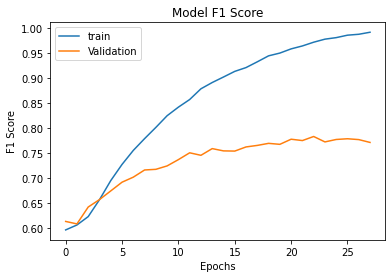

In [28]:
plt.plot(history.history['f1_m'][1:])
plt.plot(history.history['val_f1_m'][1:])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epochs')
# plt.ylim([0.7, 0.8])
plt.legend(['train','Validation'], loc='upper left')
plt.savefig('Model_F1Score.png' , dpi = 300 , transparent = 'true')
plt.show()

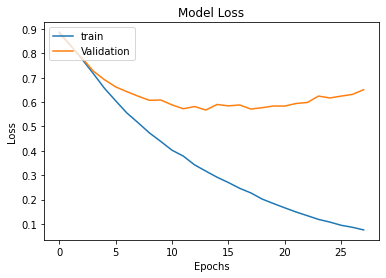

In [29]:
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
# plt.ylim([0.5, 0.6])
plt.legend(['train','Validation'], loc='upper left')
plt.savefig('Model_Loss.png' , dpi = 300 , transparent = 'true')
plt.show()

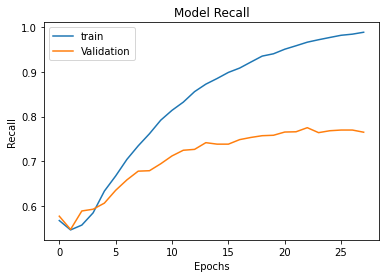

In [30]:
plt.plot(history.history['recall_m'][1:])
plt.plot(history.history['val_recall_m'][1:])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epochs')
# plt.ylim([0.7, 0.8])
plt.legend(['train','Validation'], loc='upper left')
plt.savefig('Model_Recall.png' , dpi = 300 , transparent = 'true')
plt.show()

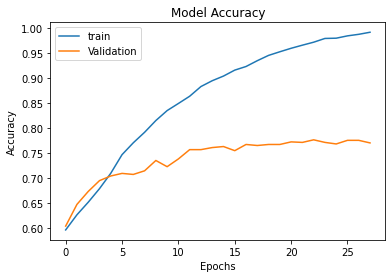

In [31]:
plt.plot(history.history['acc'][1:])
plt.plot(history.history['val_acc'][1:])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
# plt.ylim([0.7, 0.8])
plt.legend(['train','Validation'], loc='upper left')
plt.savefig('Model_Accuracy.png' , dpi = 300 , transparent = 'true')
plt.show()